# Mission
- 제공된 타이타닉 데이터 사용
- passengerid 대비 생존률을 정확하게 맞출 수 있는 머신러닝 모델 완성
- submission 파일에 아래와 같이 저장하여 kaggle로 제출

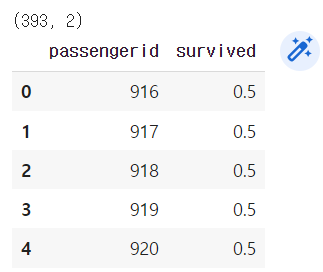

# Connect to google account

In [531]:
from google.colab import drive
import pandas as pd

# 구글 드라이브 마운트
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [532]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
# fm._rebuild()  

%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [533]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/gdrive/My Drive/titanic_kaggle/data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.submission_csv = args.default_path+'submission.csv'
args.save_results = args.default_path+"model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
SEED = 42
args.results = []

In [534]:
# 데이터 시각화 라이브러리 
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [535]:
# 지난 결과 확인
# with open(args.save_results, 'r') as file:
#     args.results = json.load(file)

# args.results

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [536]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

train.shape, test.shape

((641, 10), (275, 10))

In [537]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [538]:
ori_train.tail()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
911,911,0,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
912,912,0,3,"Cacic, Mr. Jego Grga",male,18.0,0,0,315091,8.6625,NaN,S
913,913,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q
915,915,1,1,"Candee, Mrs. Edward (Helen Churchill Hungerford)",female,53.0,0,0,PC 17606,27.4458,NaN,C


In [539]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [540]:
ori_train.describe(include = 'all')

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,916.000000,916.000000,916.000000,916,916,736.000000,916.000000,916.000000,916,916.000000,198,915
unique,NaN,NaN,NaN,915,2,NaN,NaN,NaN,703,NaN,146,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,2,589,NaN,NaN,NaN,7,NaN,4,645
mean,457.500000,0.377729,2.292576,NaN,NaN,29.698370,0.507642,0.361354,NaN,32.402710,NaN,NaN
std,264.570721,0.485084,0.838675,NaN,NaN,14.185627,1.044866,0.828054,NaN,50.506411,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,228.750000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,457.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.458300,NaN,NaN
75%,686.250000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.017700,NaN,NaN


In [541]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

##drop_duplicates

In [542]:
print(f'before : {ori_train.shape}')
ori_train.drop_duplicates(keep = 'first', inplace = True, ignore_index = True)
print(f'after : {ori_train.shape}')

before : (916, 12)
after : (916, 12)


# train_test_split

In [543]:
# 피쳐와 타겟 데이터 분리
X = ori_train.drop('survived', axis = 1)
y = ori_train['survived'] #우리가 알고자하는 생존 데이터

In [544]:
# 카테고리화
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [545]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, stratify =y , random_state = SEED)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 11), (275, 11), (641,), (275,))

# EDA

## Column Classification

In [546]:
X_tr.describe(include = 'all')

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,641.000000,641.000000,641,641,523.000000,641.000000,641.000000,641,641.000000,138,641
unique,NaN,NaN,641,2,NaN,NaN,NaN,525,NaN,109,3
top,NaN,NaN,"Klaber, Mr. Herman",male,NaN,NaN,NaN,3101295,NaN,G6,S
freq,NaN,NaN,1,420,NaN,NaN,NaN,7,NaN,3,457
mean,462.230889,2.271451,NaN,NaN,29.853576,0.492980,0.324493,NaN,31.941796,NaN,NaN
std,265.479413,0.837376,NaN,NaN,14.536210,0.993902,0.742152,NaN,47.068732,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,230.000000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.925000,NaN,NaN
50%,468.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.500000,NaN,NaN
75%,692.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.000000,NaN,NaN


In [547]:
X_tr['pclass'].nunique()

3

In [548]:
X_tr['pclass'].unique()

array([1, 3, 2])

In [549]:
X_tr['sibsp'].unique()

array([0, 2, 1, 3, 8, 4, 5])

In [550]:
X_tr['cabin'].unique()

array(['C124', 'C32', nan, 'B52 B54 B56', 'B61', 'B94', 'C2', 'D43',
       'B78', 'B36', 'D11', 'F E69', 'B58 B60', 'C65', 'C132', 'D28',
       'E63', 'C80', 'E44', 'B39', 'A23', 'C116', 'C85', 'C106',
       'B57 B59 B63 B66', 'B45', 'E34', 'G6', 'B50', 'D50', 'F', 'C39',
       'C23 C25 C27', 'D49', 'F33', 'D35', 'D34', 'A18', 'C68', 'C54',
       'B77', 'E17', 'A5', 'E36', 'D20', 'E12', 'C101', 'C78', 'E39 E41',
       'F2', 'D38', 'B5', 'C93', 'E8', 'C95', 'E101', 'C22 C26', 'B20',
       'C7', 'C83', 'B51 B53 B55', 'B4', 'A6', 'C46', 'E121', 'A34',
       'C51', 'C92', 'B26', 'D15', 'C47', 'B96 B98', 'C53', 'B79', 'D7',
       'A10', 'E33', 'C123', 'C31', 'C87', 'C86', 'E46', 'E24', 'B49',
       'C55 C57', 'B73', 'C111', 'D17', 'A11', 'C148', 'E25', 'E58',
       'C62 C64', 'B80', 'D22', 'D36', 'E49', 'C89', 'E77', 'F G63',
       'C104', 'C91', 'A32', 'A24', 'A29', 'A20', 'B38', 'C130', 'B86',
       'B22'], dtype=object)

In [551]:
X_tr['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [552]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 539 to 636
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  641 non-null    int64  
 1   pclass       641 non-null    int64  
 2   name         641 non-null    object 
 3   gender       641 non-null    object 
 4   age          523 non-null    float64
 5   sibsp        641 non-null    int64  
 6   parch        641 non-null    int64  
 7   ticket       641 non-null    object 
 8   fare         641 non-null    float64
 9   cabin        138 non-null    object 
 10  embarked     641 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 60.1+ KB


In [553]:
continous_cols = ['age', 'sibsp', 'parch', 'fare']
category_cols = ['pclass', 'gender', 'embarked']
other_cols = ['passengerid', 'name', 'ticket', 'cabin']

# ModelV0

## Missing Value

In [554]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 11))

In [555]:
train.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age            118
sibsp            0
parch            0
ticket           0
fare             0
cabin          503
embarked         0
dtype: int64

In [556]:
test.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             62
sibsp            0
parch            0
ticket           0
fare             0
cabin          215
embarked         1
dtype: int64

In [557]:
ori_te.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

In [558]:
embarked_mode = train['embarked'].mode().values[0]

test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)
test.isnull().sum(), ori_te.isnull().sum()

(passengerid      0
 pclass           0
 name             0
 gender           0
 age             62
 sibsp            0
 parch            0
 ticket           0
 fare             0
 cabin          215
 embarked         0
 dtype: int64, passengerid      0
 pclass           0
 name             0
 gender           0
 age             83
 sibsp            0
 parch            0
 ticket           0
 fare             1
 cabin          296
 embarked         0
 dtype: int64)

<AxesSubplot:ylabel='Frequency'>

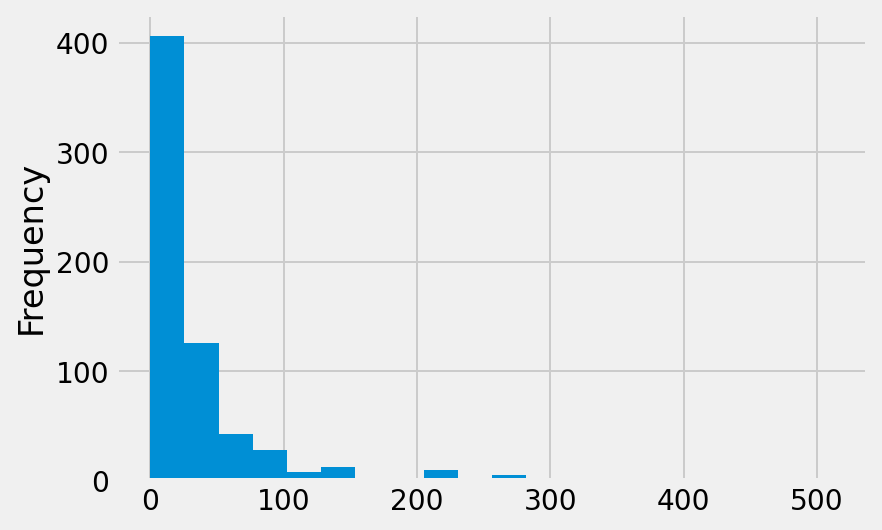

In [559]:
train['fare'].plot.hist(bins = 20)

In [560]:
fare_mode = train['fare'].median()

ori_te['fare'].fillna(fare_mode, inplace=True)
ori_te.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             0
cabin          296
embarked         0
dtype: int64

In [561]:
(train['cabin'].isnull().sum() / train.shape[0]).round(4)

0.7847

In [562]:
(test['cabin'].isnull().sum() / test.shape[0]).round(4)

0.7818

In [563]:
(ori_te['cabin'].isnull().sum() / ori_te.shape[0]).round(4)

0.7532

In [564]:
train.drop('cabin', axis = 1, inplace=True)
test.drop('cabin', axis = 1, inplace=True)
ori_te.drop('cabin', axis = 1, inplace=True)

train.isnull().sum(), test.isnull().sum(), ori_te.isnull().sum()

(passengerid      0
 pclass           0
 name             0
 gender           0
 age            118
 sibsp            0
 parch            0
 ticket           0
 fare             0
 embarked         0
 dtype: int64, passengerid     0
 pclass          0
 name            0
 gender          0
 age            62
 sibsp           0
 parch           0
 ticket          0
 fare            0
 embarked        0
 dtype: int64, passengerid     0
 pclass          0
 name            0
 gender          0
 age            83
 sibsp           0
 parch           0
 ticket          0
 fare            0
 embarked        0
 dtype: int64)

<AxesSubplot:ylabel='Frequency'>

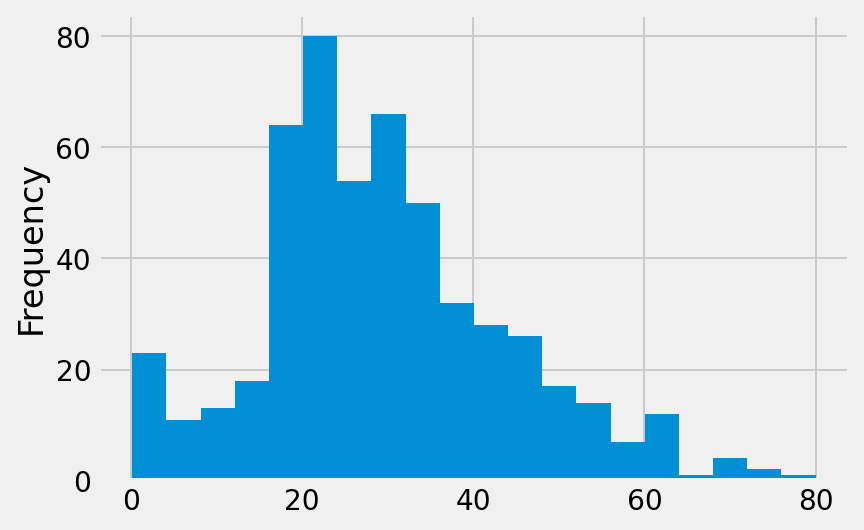

In [565]:
train['age'].plot.hist(bins = 20)

In [566]:
train['age_random'] = train['age']

random_sampling = (train['age'].dropna()).sample(train['age'].isnull().sum())
random_sampling.index = train[lambda x : x['age'].isnull()].index

train.loc[X_tr['age'].isnull(), 'age_random'] = random_sampling

#확인
train[['age', 'age_random']].isnull().sum()

age           118
age_random      0
dtype: int64

In [567]:
test['age_random'] = test['age']

random_sampling = (test['age'].dropna()).sample(test['age'].isnull().sum())
random_sampling.index = test[lambda x : x['age'].isnull()].index

test.loc[test['age'].isnull(), 'age_random'] = random_sampling

#확인
test[['age', 'age_random']].isnull().sum()

age           62
age_random     0
dtype: int64

In [568]:
ori_te['age_random'] = ori_te['age']

random_sampling = (ori_te['age'].dropna()).sample(ori_te['age'].isnull().sum())
random_sampling.index = ori_te[lambda x : x['age'].isnull()].index

ori_te.loc[ori_te['age'].isnull(), 'age_random'] = random_sampling

#확인
ori_te[['age', 'age_random']].isnull().sum()

age           83
age_random     0
dtype: int64

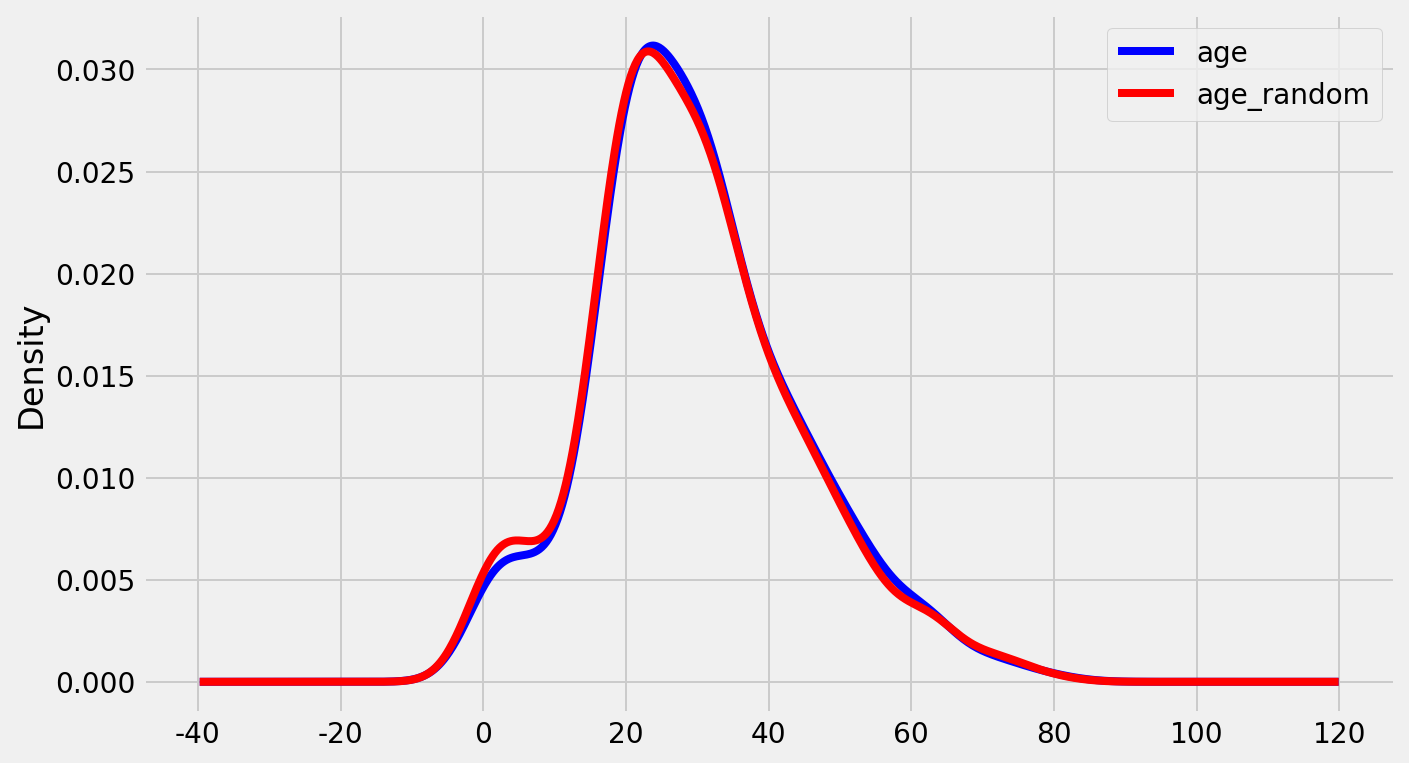

In [569]:
fig, ax = plt.subplots(figsize = (10, 6))

train['age'].plot(kind = 'kde', ax=ax, color='blue')
train['age_random'].plot(kind = 'kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')

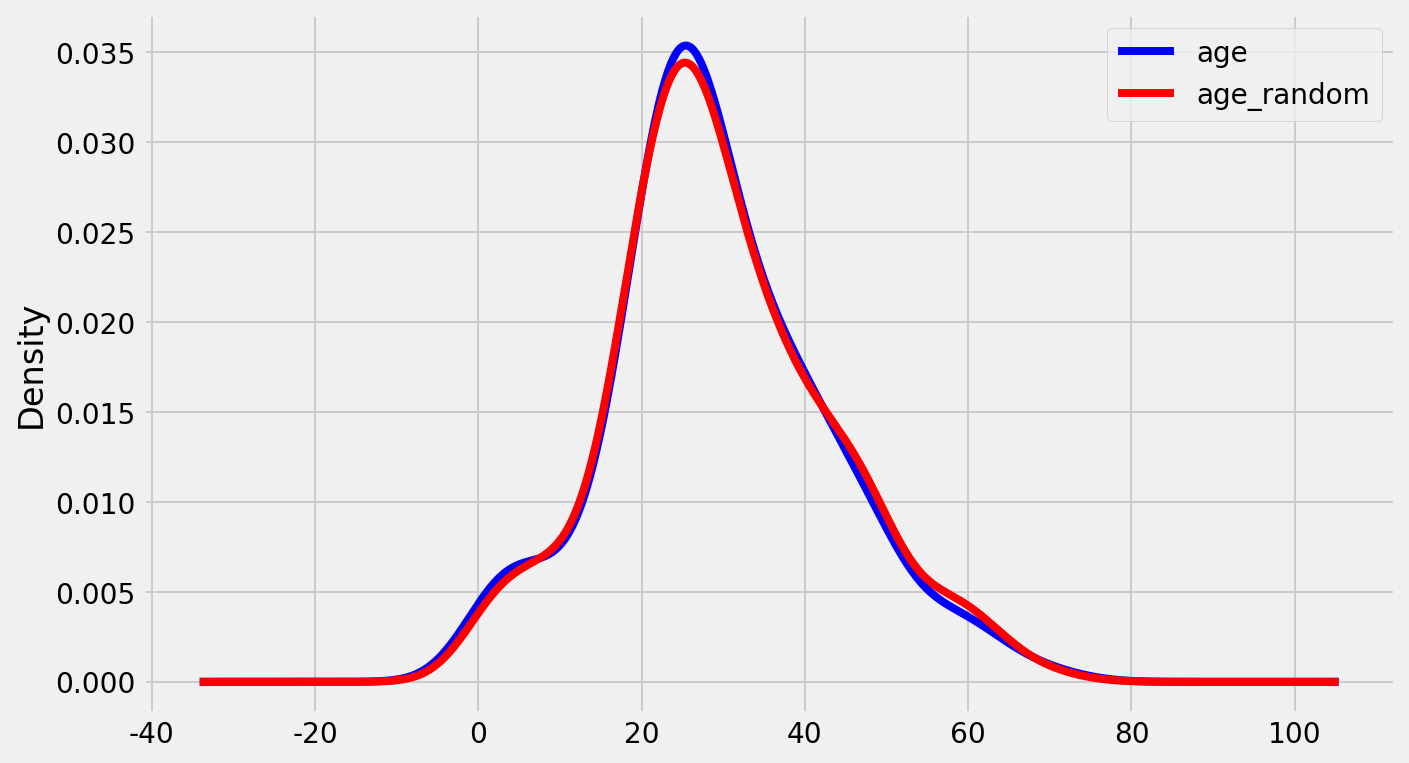

In [570]:
fig, ax = plt.subplots(figsize = (10, 6))

test['age'].plot(kind = 'kde', ax=ax, color='blue')
test['age_random'].plot(kind = 'kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')

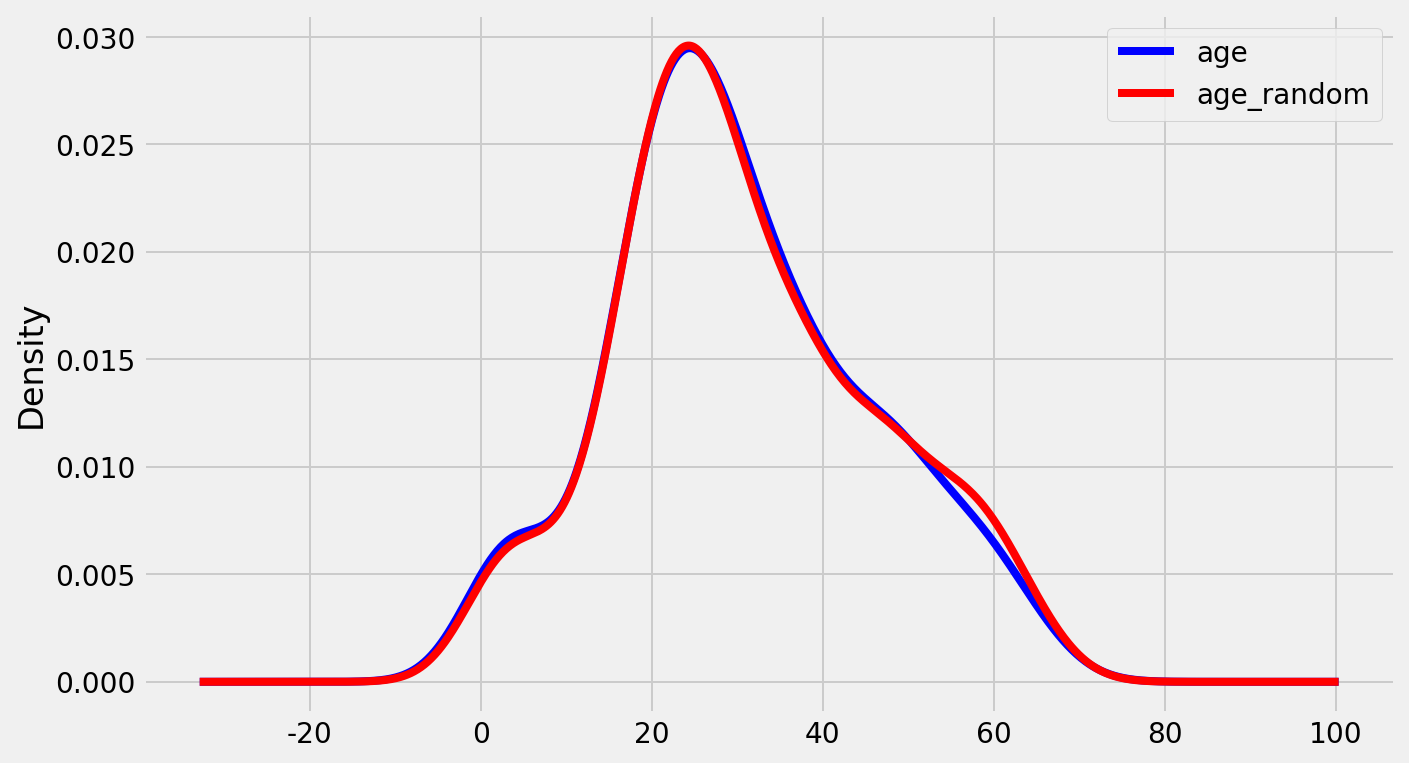

In [571]:
fig, ax = plt.subplots(figsize = (10, 6))

ori_te['age'].plot(kind = 'kde', ax=ax, color='blue')
ori_te['age_random'].plot(kind = 'kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')

In [572]:
train.drop('age', axis = 1, inplace = True)
test.drop('age', axis = 1, inplace = True)
ori_te.drop('age', axis = 1, inplace = True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

## Scaling

In [573]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 539 to 636
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  641 non-null    int64  
 1   pclass       641 non-null    int64  
 2   name         641 non-null    object 
 3   gender       641 non-null    object 
 4   sibsp        641 non-null    int64  
 5   parch        641 non-null    int64  
 6   ticket       641 non-null    object 
 7   fare         641 non-null    float64
 8   embarked     641 non-null    object 
 9   age_random   641 non-null    float64
dtypes: float64(2), int64(4), object(4)
memory usage: 55.1+ KB


In [574]:
train.select_dtypes(include = np.number)

,passengerid,pclass,sibsp,parch,fare,age_random
539,539,1,0,0,26.5500,25.0
339,339,1,0,0,135.6333,36.0
505,505,3,0,0,8.0500,22.0
492,492,3,2,0,8.6625,26.0
897,897,3,0,0,7.8792,16.0
...,...,...,...,...,...,...
538,538,3,0,0,9.3250,24.0
761,761,3,1,0,14.4542,15.0
879,879,3,0,2,24.1500,10.0
214,214,1,0,0,79.2000,24.0


In [575]:
continous_cols = ['age_random', 'sibsp', 'parch', 'fare']

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

train[continous_cols] = std.fit_transform(train[continous_cols])
test[continous_cols] = std.transform(test[continous_cols])
ori_te[continous_cols] = std.transform(ori_te[continous_cols])

train[continous_cols]

,age_random,sibsp,parch,fare
539,-0.297867,-0.496392,-0.437574,-0.114641
339,0.451466,-0.496392,-0.437574,2.204701
505,-0.502230,-0.496392,-0.437574,-0.507990
492,-0.229746,1.517451,-0.437574,-0.494967
897,-0.910957,-0.496392,-0.437574,-0.511622
...,...,...,...,...
538,-0.365988,-0.496392,-0.437574,-0.480881
761,-0.979079,0.510529,-0.437574,-0.371823
879,-1.319684,-0.496392,2.259396,-0.165670
214,-0.365988,-0.496392,-0.437574,1.004810


In [584]:
train[continous_cols].shape, test[continous_cols].shape, ori_te[continous_cols].shape

((641, 4), (275, 4), (393, 4))

## Encoding

In [577]:
pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [588]:
category_cols = ['pclass', 'gender', 'embarked']

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names = True)
enco_tr = pd.DataFrame()
enco_te = pd.DataFrame()
enc_ori_te = pd.DataFrame()

for col in train[category_cols].columns:
  _enco = encoder.fit_transform(train[col].astype('category'))
  enco_tr = pd.concat([enco_tr, _enco], axis=1)

  _enco = encoder.transform(test[col].astype('category'))
  enco_te = pd.concat([enco_te, _enco], axis=1)
  
  _enco = encoder.transform(ori_te[col].astype('category'))
  enc_ori_te = pd.concat([enc_ori_te, _enco], axis=1)

In [589]:
enco_tr.shape, enco_te.shape, enc_ori_te.shape

((641, 8), (275, 8), (393, 8))

In [590]:
train.head()

,passengerid,pclass,name,gender,sibsp,parch,ticket,fare,embarked,age_random
539,539,1,"Klaber, Mr. Herman",male,-0.496392,-0.437574,113028,-0.114641,S,-0.297867
339,339,1,"Young, Miss. Marie Grice",female,-0.496392,-0.437574,PC 17760,2.204701,C,0.451466
505,505,3,"Davies, Mr. Evan",male,-0.496392,-0.437574,SC/A4 23568,-0.507990,S,-0.502230
492,492,3,"Kink, Mr. Vincenz",male,1.517451,-0.437574,315151,-0.494967,S,-0.229746
897,897,3,"Linehan, Mr. Michael",male,-0.496392,-0.437574,330971,-0.511622,Q,-0.910957


## Training

In [591]:
tr = pd.concat([train[continous_cols], enco_tr], axis=1)
te = pd.concat([test[continous_cols], enco_te], axis=1)
ori = pd.concat([ori_te[continous_cols], enc_ori_te], axis=1)

tr.shape, te.shape,  ori.shape

((641, 12), (275, 12), (393, 12))

In [592]:
tr.head()

,age_random,sibsp,parch,fare,pclass_1.0,pclass_3.0,pclass_2.0,gender_male,gender_female,embarked_S,embarked_C,embarked_Q
539,-0.297867,-0.496392,-0.437574,-0.114641,1,0,0,1,0,1,0,0
339,0.451466,-0.496392,-0.437574,2.204701,1,0,0,0,1,0,1,0
505,-0.502230,-0.496392,-0.437574,-0.507990,0,1,0,1,0,1,0,0
492,-0.229746,1.517451,-0.437574,-0.494967,0,1,0,1,0,1,0,0
897,-0.910957,-0.496392,-0.437574,-0.511622,0,1,0,1,0,0,0,1


In [593]:
tr.isnull().sum().sum(), te.isnull().sum().sum(), ori.isnull().sum().sum()

(0, 0, 0)

In [595]:
from sklearn.tree import DecisionTreeClassifier

modelV0 = DecisionTreeClassifier(random_state=args.random_state)

print(f'{tr.shape} / {y_tr.shape}')
modelV0.fit(tr, y_tr)

(641, 12) / (641,)


DecisionTreeClassifier(random_state=42)

## Evaluation

In [596]:
score_tr = modelV0.score(tr, y_tr)
score_te = modelV0.score(te, y_te) 

score_tr, score_te  

(0.9906396255850234, 0.8181818181818182)

In [599]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV0.predict_proba(te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.811740890688259


In [600]:
ori_te_pred = modelV0.predict_proba(ori)[:,1]
ori_te_pred.shape

(393,)

In [602]:
df_feature_importances = pd.DataFrame(modelV0.feature_importances_, tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(12, 2)


,index,0
0,gender_male,0.532091
1,age_random,0.204676
2,fare,0.176452
3,pclass_3.0,0.025995
4,sibsp,0.024247
5,parch,0.019035
6,embarked_C,0.007350
7,embarked_Q,0.005904
8,embarked_S,0.004249
9,pclass_1.0,0.000000


In [603]:
args.results.append(
    {
        'model': 'modelV0',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0227'
    }
)

args.results

[{'model': 'modelV0',
  'score_tr': 0.9906396255850234,
  'score_te': 0.8181818181818182,
  'auc_te': 0.811740890688259,
  'ori_te_pred': array([1.  , 1.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.5 , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 1.  ,
         0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 0.  , 1.  , 0.  , 1.  ,
         1.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 1.  ,
         0.  , 1.  , 0.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  ,
         1.  , 0.25, 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 0.  , 1.  ,
         0.  , 0.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ,
         0.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
         0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 1.  ,
         0.  , 0.  , 1.  , 0.  , 0.  , 

# Submission

In [604]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.99064,0.818182,0.811741,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",11,"[gender_male, age_random, fare, pclass_3.0, si...",0227


In [606]:
submission = pd.read_csv(args.submission_csv)
submission.head()

,passengerid,survived
0,916,0.841330
1,917,0.883158
2,918,0.865411
3,919,0.101740
4,920,0.959227


In [607]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,1.0
1,917,1.0
2,918,1.0
3,919,0.0
4,920,1.0
5,921,1.0
6,922,0.0
7,923,0.0
8,924,0.0
9,925,0.0


In [608]:
submission.to_csv(args.submission_csv, header=True, index=False)

# Save Results

In [609]:
args.save_results

'/content/gdrive/My Drive/titanic_kaggle/data/model_results.json'

In [610]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_te', 'ori_te_pred',
       'len_features', 'feaute_importances', 'create_dt'],
      dtype='object')

In [611]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 

In [612]:
df_results.to_json(args.save_results, orient="records")

In [613]:
df_results.head()

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
0,modelV0,0.99064,0.818182,0.811741,11,"[gender_male, age_random, fare, pclass_3.0, si...",0227


In [614]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

[{'model': 'modelV0',
  'score_tr': 0.9906396256,
  'score_te': 0.8181818182,
  'auc_te': 0.8117408907,
  'len_features': 11,
  'feaute_importances': ['gender_male',
   'age_random',
   'fare',
   'pclass_3.0',
   'sibsp',
   'parch',
   'embarked_C',
   'embarked_Q',
   'embarked_S',
   'pclass_1.0',
   'pclass_2.0'],
  'create_dt': '0227'}]